## <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea">Assignment 8: Plants Seedling Classification (Computer Vision)</span>

##  <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#0e92ea"> Objective:</span>

<p align="center" style="font-family: Arial;color:#0e92ea;font-size:1em;">
<p style="font-family: Arial;color:#0e92ea;font-size:1em;">
This dataset contains images of unique plants belonging to 12 different species.
The data file names are:
images.npy
Label.csv
Due to the large volume of data, the images were converted to numpy arrays and stored in images.npy file and the corresponding labels are also put into Labels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.
The goal of the project is to create a classifier capable of determining a plant's species from an image, i.e 
build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories:
</p>
<ol style="font-family: Arial;color:#0e92ea;font-size:1em;">
    <li>Black-grass</li> 
    <li>Charlock</li> 
    <li>Cleavers</li> 
    <li>Common Chickweed</li> 
    <li>Common Wheat</li> 
    <li>Fat Hen</li> 
    <li>Loose Silky-bent</li> 
    <li>Maize</li> 
    <li>Scentless Mayweed</li> 
    <li>Shepherds Purse</li> 
    <li>Small-flowered Cranesbill</li> 
    <li>Sugar beet</li> 
</ol>
</p>

In [ ]:
# Clear Session
from keras import backend
backend.clear_session()

import PIL
import cv2
import math
import keras
import warnings
import random
import pprint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

from keras import losses
from keras.models import Sequential
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import BatchNormalization

from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from PIL import Image
from matplotlib import pyplot

import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from google.colab import drive


warnings.filterwarnings('ignore')

# Load Data

In [ ]:
# Mound Drive
# drive.mount('/content/drive')

# Set Random Seed
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED) 
tf.random.set_seed(RANDOM_SEED)

In [ ]:
base_folder = "/content/drive/MyDrive/Colab Notebooks"
images_data_file_path = f"{base_folder}/images.npy"
images_labels_file_path = f"{base_folder}/Labels.csv"

images_data = np.load(images_data_file_path)
images_labels = pd.read_csv(images_labels_file_path)

# Data Exploration

### Combine the Labels and Images  

In [ ]:
images_data[0].shape

(128, 128, 3)

In [ ]:
type(images_data)

numpy.ndarray

In [ ]:
def CreateImageLabelsDataFrame(labels_df, images_ndarry):
  df = labels_df.copy()
  df['Image_Matrix'] = pd.Series(images_ndarry.tolist())
  df['Label'] = df['Label'].astype("string")
  return df

In [ ]:
main_data = CreateImageLabelsDataFrame(images_labels, images_data)
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Label         4750 non-null   string
 1   Image_Matrix  4750 non-null   object
dtypes: object(1), string(1)
memory usage: 74.3+ KB


### Explore the Distribution of the Data

In [ ]:
def GetLabelsCountDf(image_labels_df):
  col_name = "Label"

  plant_names             = image_labels_df[col_name].unique()
  plant_names_count       = []
  plant_names_count_perc  = []
  id                      = []

  count = 0
  for plant_name in  plant_names:
      total_count = image_labels_df[col_name].count()
      plant_name_count = image_labels_df[image_labels_df[col_name] == plant_name][col_name].count()
      plant_names_count.append(plant_name_count)
      plant_names_count_perc.append(f"{str(round((plant_name_count/total_count) * 100, 2))}%")
      id.append(count)
      count = count + 1

  return pd.DataFrame({
      "id"            :id,
      "Plant Name"    :plant_names,
      "Count"         :plant_names_count,
      "Category %"    :plant_names_count_perc
  })


In [ ]:
GetLabelsCountDf(main_data)

,id,Plant Name,Count,Category %
0,0,Small-flowered Cranesbill,496,10.44%
1,1,Fat Hen,475,10.0%
2,2,Shepherds Purse,231,4.86%
3,3,Common wheat,221,4.65%
4,4,Common Chickweed,611,12.86%
5,5,Charlock,390,8.21%
6,6,Cleavers,287,6.04%
7,7,Scentless Mayweed,516,10.86%
8,8,Sugar beet,385,8.11%
9,9,Maize,221,4.65%


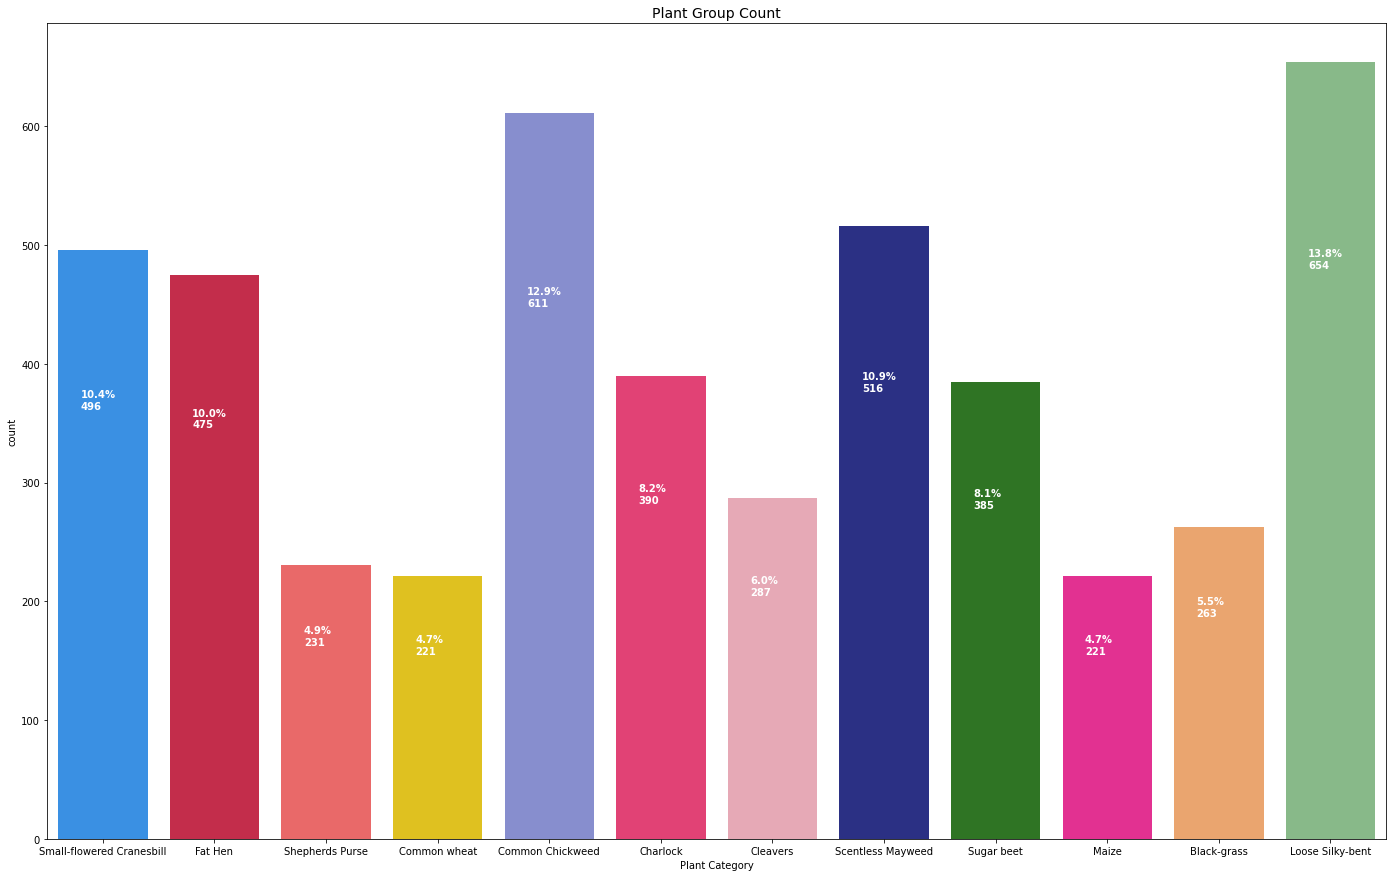

In [ ]:
color_palettex = ["dodgerblue", "crimson", "#ff5353", "gold", "#7b85da", "#fb286b", "#f09fb0", "#1c2393", "#258117","#ff1493", "#ffa35a", "#80c181", "#ffa35a", "#ff1493"]

fig, ax = plt.subplots(figsize=(24,15))

sns.countplot(x="Label", data=images_labels, palette=color_palettex, ax=ax)
ax.set_xlabel("Plant Category")                                           
ax.set_title("Plant Group Count", fontsize=14)

total = 0
for p in ax.patches:
    if p.get_height() > 0:
        total += p.get_height()

for p in ax.patches:
    if p.get_height() > 0:
        percentage = str(((p.get_height() / total) * 100).round(1))+ '%'
        txt_x = p.get_x() + p.get_width()/4
        txt_y = p.get_height() - p.get_height()/4
        ax.text(txt_x,txt_y-10, p.get_height(), color="white", weight="bold")
        ax.text(txt_x,txt_y, percentage, color="white", weight="bold")
      

plt.show()

### Overall Observations

- We seem to be missing some data for other plants, some plants have 654 images and some have 231, this might make the nueral network better at understanding/classifying other plants than others.
- We might need to generate more images for the plants with low data by rotating the imaghes and applying some regularisation techniques.

### Explore the Plant Images

In [ ]:
def DisplayPlantCategoryPlot(df):
  unique_plant_names = df['Label'].unique()
  images = []
  for plant_name in unique_plant_names:
    images.append(df[df['Label'] == plant_name].head(1)['Image_Matrix'].tolist()[0])

  grouped_plants_df = pd.DataFrame({"Label": unique_plant_names, "Image_Matrix": images})
  fig, axes = plt.subplots(3, 4, figsize=(16, 6))

  image_index = 0
  for row in range(3):
      for col in range(4):
        if (image_index < len(unique_plant_names)):
          axes[row][col].imshow(grouped_plants_df['Image_Matrix'][image_index])
          axes[row][col].set_title(grouped_plants_df['Label'][image_index])
          image_index += 1

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.8, 
                      top=1, 
                      wspace=0.6, 
                      hspace=0.6)
  plt.show()

In [ ]:
def ExplorePlant(data, plant_name):
  plant_images = data[data['Label'] == plant_name]['Image_Matrix'].tolist()
  fig, axes = plt.subplots(3, 4, figsize=(16, 6))

  image_index = 0
  for row in range(3):
      for col in range(4):
          image_index = random.randrange(len(plant_images))
          axes[row][col].imshow(plant_images[image_index])
          axes[row][col].set_title(f"index={image_index}")

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=1, 
                      wspace=0.6, 
                      hspace=0.6)
  plt.show()

### Explore Each Plant from each Group

#### Observations
- All plants in the dataset are green and on a grayish background
- Most of these plants look alike, hopefully we can derive kenerls /edges that will help separate them apart.

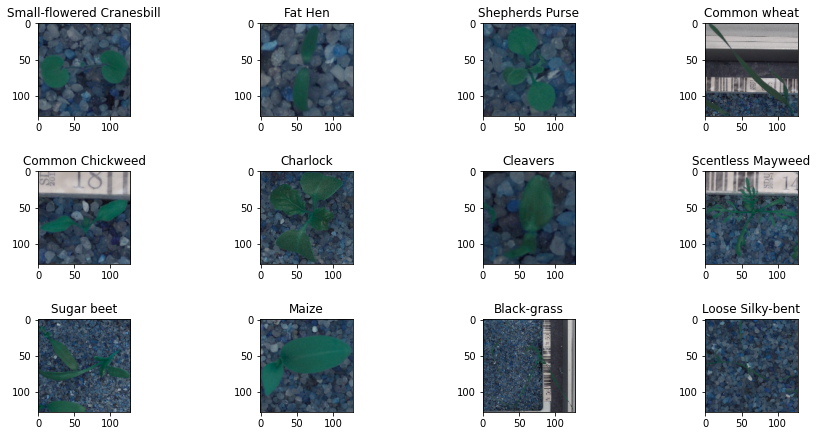

In [ ]:
DisplayPlantCategoryPlot(main_data)

### Explore : Small-flowered Cranesbill

- The plant seems to have two groups of images: 
  - (1) ones with leaves that have more edges and have more leafs (grown and congested)
  - (2) ones that have only two leafs and few edges on the leasfs.
  - (3) both cases seem to have images with right amount of rotations but this is only observations from a random sample.

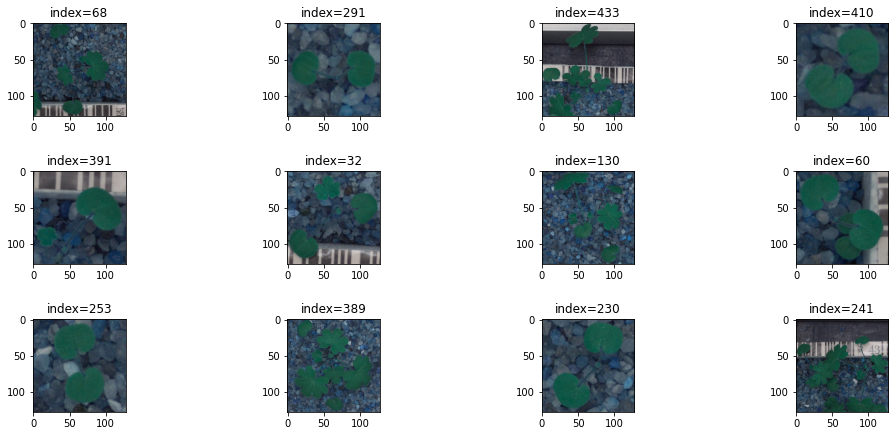

In [ ]:
ExplorePlant(
    data        = main_data,
    plant_name  = "Small-flowered Cranesbill")

### Explore : Black-grass
- The images are a bit congested, the grass leasfs are too small, we need to find a way to obscure the background so it does not overcrowed the leafe image. Bluring the image might work in this case

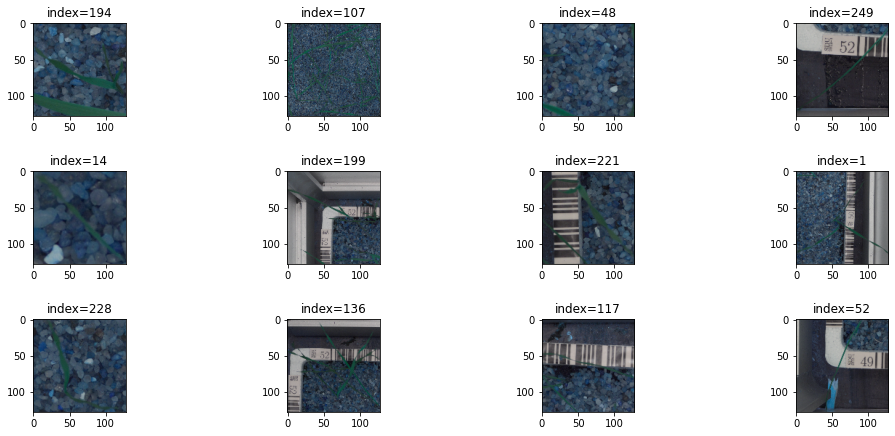

In [ ]:
ExplorePlant(
    data        = main_data,
    plant_name  = "Black-grass")

### Explore : Charlock

- The plant looks like Small-flowered Cranesbill when it only has two leafs, the differentiator is the rounded heart-like outer edges.
- Could use some bluring to obscure the background.
- Images seem to have a good amount of rotations just looking at the sample data.

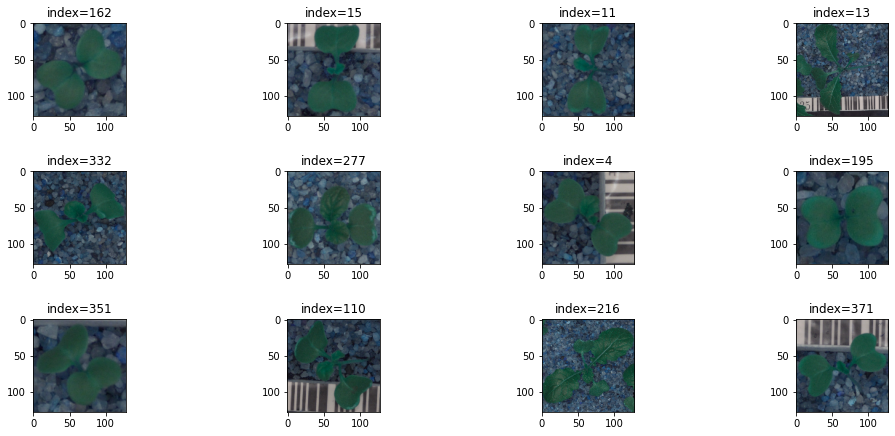

In [ ]:
ExplorePlant(
    data        = main_data,
    plant_name  = "Charlock")

### Overall Observations

- Plant leafs seem to be obscured by the grey-rocks background.
- We will explore different image processing techniques to try to obscure the background and amplify the plant leafs.

# Data Processing

### Apply Gausian Blur

In [ ]:
def Blur(img):
  img_temp = Image.fromarray(np.asarray(img).astype(np.uint8))
  imcv = cv2.cvtColor(np.asarray(img_temp), cv2.COLOR_RGB2BGR)
  return cv2.GaussianBlur(imcv, ksize=(5, 5), sigmaX=5)

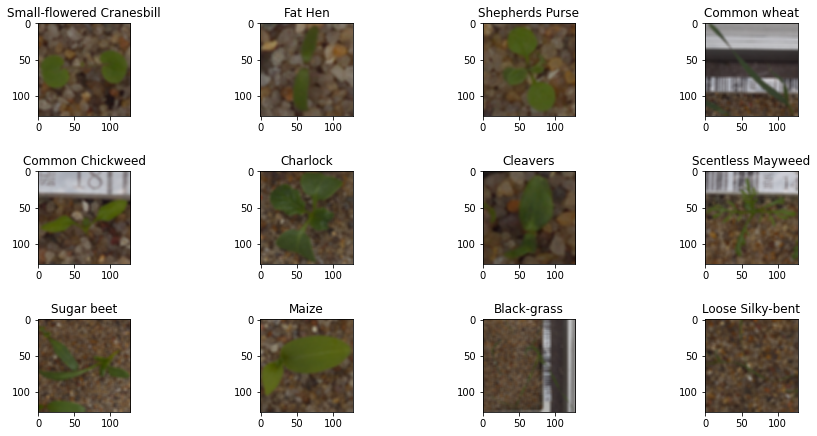

In [ ]:
main_data_temp = main_data.copy()
main_data_temp['Image_Matrix'] = main_data_temp['Image_Matrix'].apply(Blur)
DisplayPlantCategoryPlot(main_data_temp)

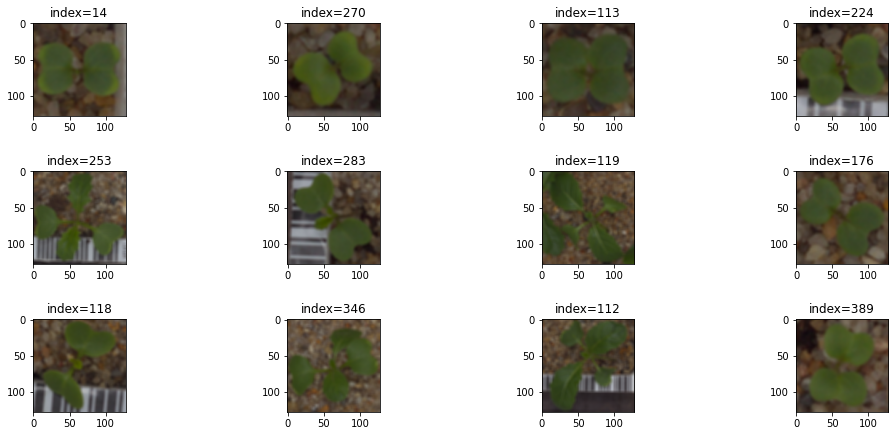

In [ ]:
ExplorePlant(
    data        = main_data_temp,
    plant_name  = "Charlock")

- Using Gausiab blue we were able to remove the background noise from grey to brown which is easily disintinguished from the green color.

- This might not be effective in the case where these plants are next to other green plants that look similar

In [ ]:
main_data = main_data_temp.copy()

### Apply Grey Scale

In [ ]:
def GrayScale(img):
    weights=[0.1, 0.6, 0.2]
    img_temp = Image.fromarray(np.asarray(img).astype(np.uint8))
    size = 128
    image_pixel_matrix = img_temp.load()
    for i in range(size):
        for j in range(size):
            red, green, blue = img_temp.getpixel((i, j))
            gray_scale = int((
                weights[0]*red+
                weights[1]*green+
                weights[2]*blue)/3)
            image_pixel_matrix[i, j]= (gray_scale, gray_scale, gray_scale)
    return img_temp

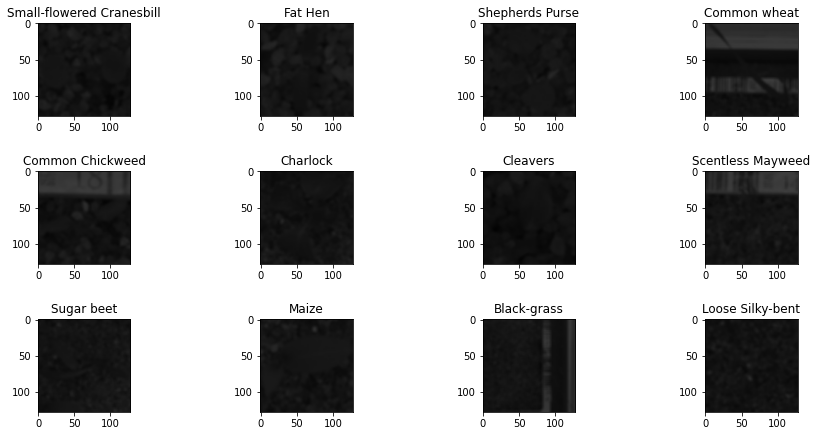

In [ ]:
main_data_temp = main_data.copy()
main_data_temp['Image_Matrix'] = main_data_temp['Image_Matrix'].apply(GrayScale)
DisplayPlantCategoryPlot(main_data_temp)

- Grey scale takes away a lot of information. We will thus have to leave it out.

### Apply Cmap Filter

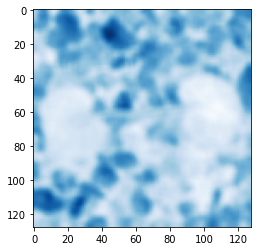

In [ ]:
img_temp = Image.fromarray(np.asarray(main_data['Image_Matrix'][0]).astype(np.uint8))
plt.imshow(img_temp.getchannel('B'), cmap="Blues")

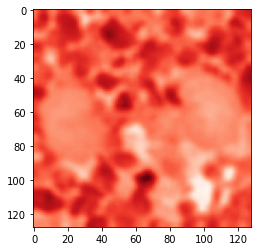

In [ ]:
img_temp = Image.fromarray(np.asarray(main_data['Image_Matrix'][0]).astype(np.uint8))
plt.imshow(img_temp.getchannel('R'), cmap="Reds")

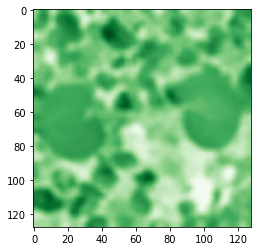

In [ ]:
img_temp = Image.fromarray(np.asarray(main_data['Image_Matrix'][0]).astype(np.uint8))
plt.imshow(img_temp.getchannel('G'), cmap="Greens")

- This too also doesnt help amplify the green part of the plant

# Model Building and Evaluation

### Split the Data

In [ ]:
# Separating data into X and Y

X = np.asarray(main_data['Image_Matrix'].values.tolist())
Y = np.asarray(main_data[['Label']].values.tolist())


In [ ]:
X.shape

(4750, 128, 128, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print(x_train.shape, x_test.shape)

(3800, 128, 128, 3) (950, 128, 128, 3)


In [ ]:
print(y_train.shape, y_test.shape)

(3800, 1) (950, 1)


### Reshape the Data

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 128, 128, 3)
x_test = x_test.reshape(x_test.shape[0], 128, 128, 3)

In [ ]:
print(x_train.shape, x_test.shape)

(3800, 128, 128, 3) (950, 128, 128, 3)


### Normalize the Data

In [ ]:
x_train_normalized = x_train.astype('float32')/255.0
x_test_normalized = x_test.astype('float32')/255.0

In [ ]:
print(x_train_normalized.shape, x_test_normalized.shape)

(3800, 128, 128, 3) (950, 128, 128, 3)


### Convert Target to OneHot Encoding

In [ ]:
label_binarizer = LabelBinarizer()
y_train_encoded =label_binarizer.fit_transform(y_train)
y_test_encoded =label_binarizer.fit_transform(y_test)

In [ ]:
print(y_train_encoded.shape)
print(y_test_encoded.shape)

(3800, 12)
(950, 12)


### Model

In [ ]:
backend.clear_session()

In [ ]:
model_data = {
    "x_train": x_train_normalized,
    "y_train": y_train_encoded,
    "x_test" : x_test_normalized,
    "y_test" : y_test_encoded,
}

model_evaluation_scores = {
    "Hidden Layer Activation" : [],
    "Output Layer Activation" : [],
    "Loss"                    : [],
    "Weight Initialisation"   : [],
    "Max Accuracy Train"      : [],
    "Max Accuracy Test"       : [],
    "Max Recall Train"        : [],
    "Max Recall Test"         : []
}

In [ ]:
def GetBaseModel(current_optimiser, data, activation_funtion, scores, initializer='random_normal'):
    backend.clear_session()

    model = keras.Sequential()
    model.add(Conv2D(64, (3, 3), activation=activation_funtion, padding="same", input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2), padding = 'same'))
    model.add(Conv2D(32, (3, 3), activation=activation_funtion, padding="same"))
    model.add(MaxPooling2D((2, 2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), activation=activation_funtion, padding="same"))
    model.add(Flatten())
    model.add(Dense(32, activation=activation_funtion))
    model.add(Dropout(0.25))
    model.add(Dense(16, activation=activation_funtion))
    model.add(Dense(12, activation='softmax'))

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=['accuracy', 'FalsePositives', 'TruePositives', 'Recall'])
    history = model.fit(
        data['x_train'],
        data['y_train'],
        epochs=50,
        validation_split=0.2,
        verbose=1)

    model.summary()
    print(model.metrics_names)
    history = pd.DataFrame.from_dict(history.history)
    history_stats = history.describe().T
    
    scores["Hidden Layer Activation"].append(activation_funtion)
    scores["Output Layer Activation"].append("Softmax")
    scores["Max Accuracy Train"].append(history_stats.loc['accuracy']['max'])
    scores["Max Accuracy Test"].append(history_stats.loc['val_accuracy']['max'])
    scores["Max Recall Train"].append(history_stats.loc['recall']['max'])
    scores["Max Recall Test"].append(history_stats.loc['val_recall']['max'])
    scores["Weight Initialisation"].append(initializer)
    scores["Loss"].append("binary_crossentropy")
    
    return {
        'Model'   : model,
        'History' : history,
        "Stats"   : scores
    }

def Scores(dic):
    return pd.DataFrame.from_dict(dic).T

def GetModelPredictions(model, data):
    y_pred = model.predict(data['x_test'])
    y_pred = np.round(y_pred,0)
    print(classification_report(data['y_test'],y_pred))
    return y_pred

def DisplayConfusionMatrix(y_actual, y_predict, encoder):
  encoded = np.argmax(y_actual, axis=1)
  encoded_pred = np.argmax(y_predict, axis=1)

  cm = confusion_matrix(encoded, encoded_pred)
  fig, ax = plt.subplots(figsize=(18,18)) 

  sns.heatmap(data=cm, annot=True, linewidths=.5, ax=ax, xticklabels=encoder.classes_, yticklabels=encoder.classes_)
  plt.show()
    
def ShowModelStats(history, actual_y, predictions_y, label, encoder):    
    # chart 1
    DisplayConfusionMatrix(actual_y, predictions_y, encoder)

    # chart 2
    plt.figure(figsize= (18,9))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Model Accurracy Summary: {label}')
    plt.ylabel('Score')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='best')
    plt.show()
    
    # chart 3
    plt.figure(figsize= (18,9))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'Model Loss Summary: {label}')
    plt.ylabel('Score')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='best')
    plt.show()

    # chart 4
    plt.figure(figsize= (18,9))
    plt.plot(history['recall'])
    plt.plot(history['val_recall'])
    plt.title(f'Model Recall Summary: {label}')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['recall', 'val_recall'], loc='best')
    plt.show()
    
def GetModelStats(model):
    evaluation_history = model['History']
    return evaluation_history.describe()

def GetModelAccuracy():
  y_test_pred_ln3 = model_3.predict(X_test)
  y_test_pred_classes_ln3 = np.argmax(y_test_pred_ln3, axis=1)
  return accuracy_score(normal_y_test, y_test_pred_classes_ln3)


## Random Initiaization

In [ ]:
model = GetBaseModel(
    current_optimiser       = "adam",
    data                    = model_data,
    activation_funtion      = 'relu',
    scores                  = model_evaluation_scores)
model_evaluation_scores = model['Stats']

Epoch 1/50
95/95 [==============================] - 17s 169ms/step - loss: 2.2833 - accuracy: 0.2092 - false_positives: 46.0000 - true_positives: 75.0000 - recall: 0.0247 - val_loss: 2.4166 - val_accuracy: 0.2289 - val_false_positives: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
95/95 [==============================] - 15s 163ms/step - loss: 1.9508 - accuracy: 0.3322 - false_positives: 227.0000 - true_positives: 432.0000 - recall: 0.1421 - val_loss: 2.3182 - val_accuracy: 0.3329 - val_false_positives: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
95/95 [==============================] - 16s 164ms/step - loss: 1.7554 - accuracy: 0.4069 - false_positives: 250.0000 - true_positives: 633.0000 - recall: 0.2082 - val_loss: 2.0614 - val_accuracy: 0.4355 - val_false_positives: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
95/95 [==============================] - 15s 163ms/step - loss: 1.6830

In [ ]:
model['History'].describe().T

,count,mean,std,min,25%,50%,75%,max
loss,50.0,0.937713,0.395752,0.565431,0.650074,0.789570,1.089435,2.283306
accuracy,50.0,0.666493,0.136655,0.209211,0.594408,0.711842,0.773355,0.808224
false_positives,50.0,330.600000,79.494834,46.000000,274.500000,326.500000,406.000000,440.000000
true_positives,50.0,1692.620000,540.036465,75.000000,1416.750000,1899.500000,2098.750000,2231.000000
recall,50.0,0.556783,0.177644,0.024671,0.466036,0.624836,0.690378,0.733882
val_loss,50.0,1.583622,0.607457,1.014315,1.221131,1.408985,1.706747,4.852384
val_accuracy,50.0,0.609053,0.097902,0.228947,0.575000,0.634211,0.673355,0.713158
val_false_positives,50.0,140.340000,73.339471,0.000000,103.750000,153.500000,184.750000,344.000000
val_true_positives,50.0,363.480000,141.354272,0.000000,332.750000,421.000000,455.500000,494.000000
val_recall,50.0,0.478263,0.185992,0.000000,0.437829,0.553947,0.599342,0.650000


In [ ]:
y_predictions = GetModelPredictions(model['Model'], model_data)

              precision    recall  f1-score   support

           0       0.35      0.18      0.24        71
           1       0.40      0.89      0.55        66
           2       0.71      0.27      0.39        55
           3       0.81      0.68      0.74       116
           4       0.30      0.34      0.32        44
           5       0.97      0.34      0.50        91
           6       0.62      0.51      0.56       125
           7       0.88      0.36      0.51        39
           8       0.57      0.32      0.41       100
           9       0.50      0.12      0.19        52
          10       0.86      0.69      0.77       107
          11       0.48      0.50      0.49        84

   micro avg       0.59      0.47      0.52       950
   macro avg       0.62      0.43      0.47       950
weighted avg       0.64      0.47      0.51       950
 samples avg       0.47      0.47      0.47       950



In [ ]:
model['History']

,loss,accuracy,false_positives,true_positives,recall,val_loss,val_accuracy,val_false_positives,val_true_positives,val_recall
0,2.283306,0.209211,46.0,75.0,0.024671,2.416647,0.228947,0.0,0.0,0.000000
1,1.950836,0.332237,227.0,432.0,0.142105,2.318248,0.332895,0.0,0.0,0.000000
2,1.755437,0.406908,250.0,633.0,0.208224,2.061354,0.435526,0.0,0.0,0.000000
3,1.683036,0.423026,284.0,671.0,0.220724,1.841984,0.448684,5.0,36.0,0.047368
4,1.591127,0.455921,301.0,737.0,0.242434,1.571043,0.557895,3.0,66.0,0.086842
5,1.478222,0.479276,351.0,841.0,0.276645,1.483334,0.556579,19.0,121.0,0.159211
6,1.421313,0.492105,368.0,936.0,0.307895,1.365989,0.540789,33.0,187.0,0.246053
7,1.330858,0.516776,413.0,1063.0,0.349671,1.199301,0.630263,35.0,217.0,0.285526
8,1.284061,0.541447,420.0,1169.0,0.384539,1.327065,0.530263,78.0,205.0,0.269737
9,1.251462,0.555263,410.0,1186.0,0.390132,1.524541,0.592105,138.0,331.0,0.435526


### Observations

- Black Grass:  Has more incorrect predictions than correct ones. 25 times it was predicted right and 33 times it was mistaken for Loose Silky Belt.

- Cleavers has more mis-classfications for Charlock and Black Grass

- Fat Hen also has more incorrectclassiffications for Black Grass.

- Suger Beet also 28 times incorrectly classififed ast Charlock.

- Scentless weed incorrectly classified as Black Grass

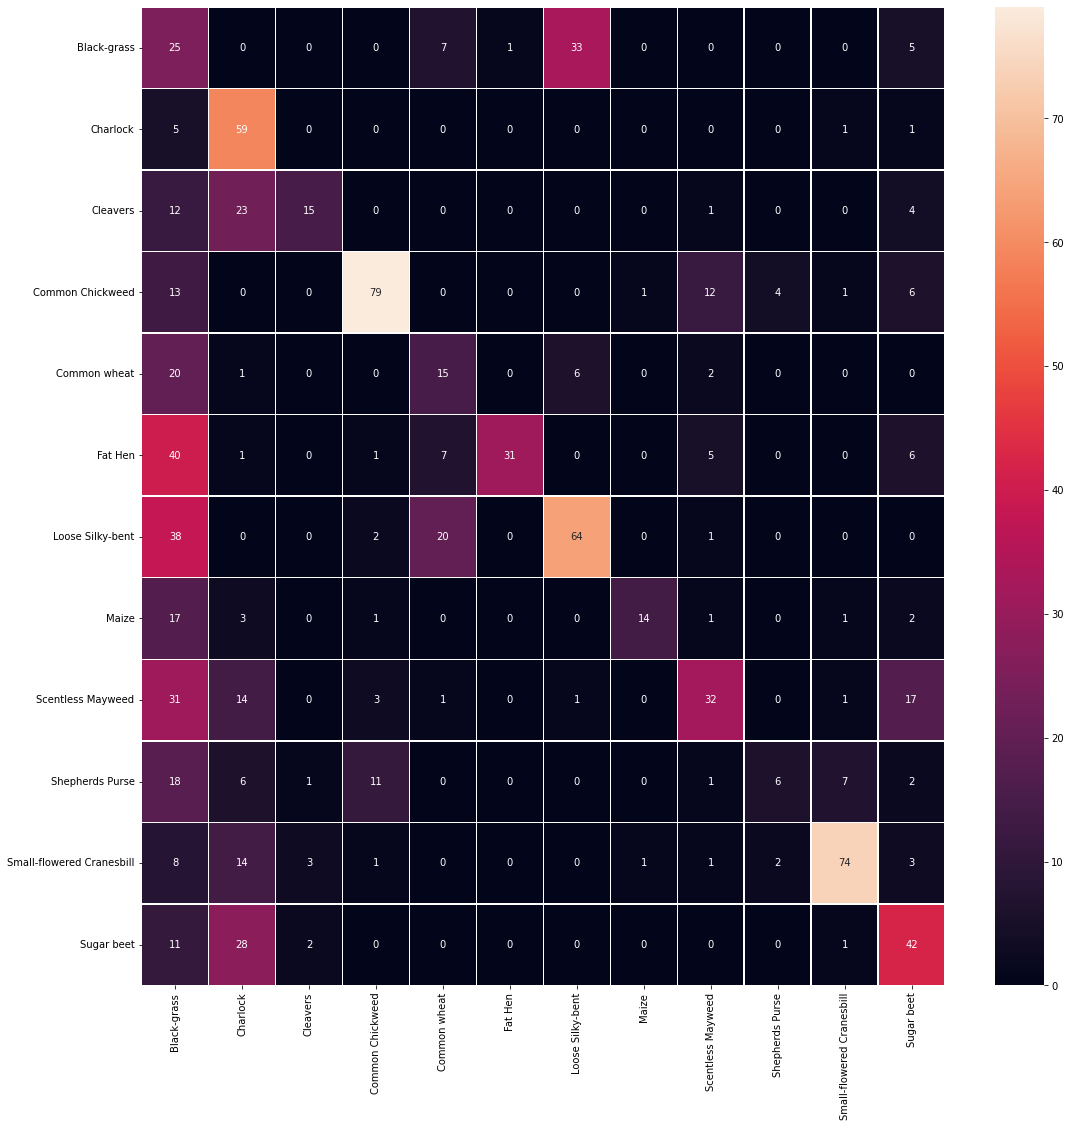

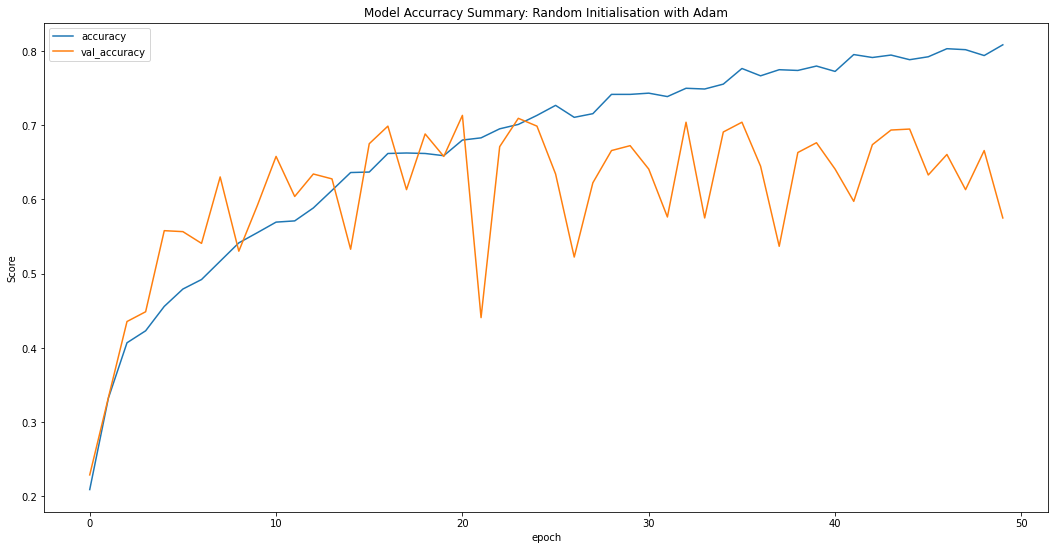

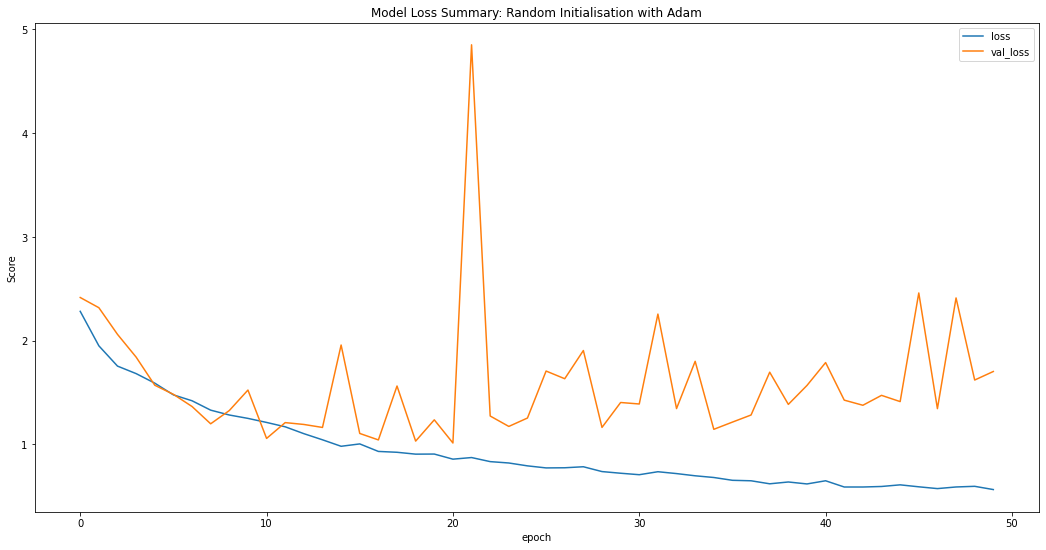

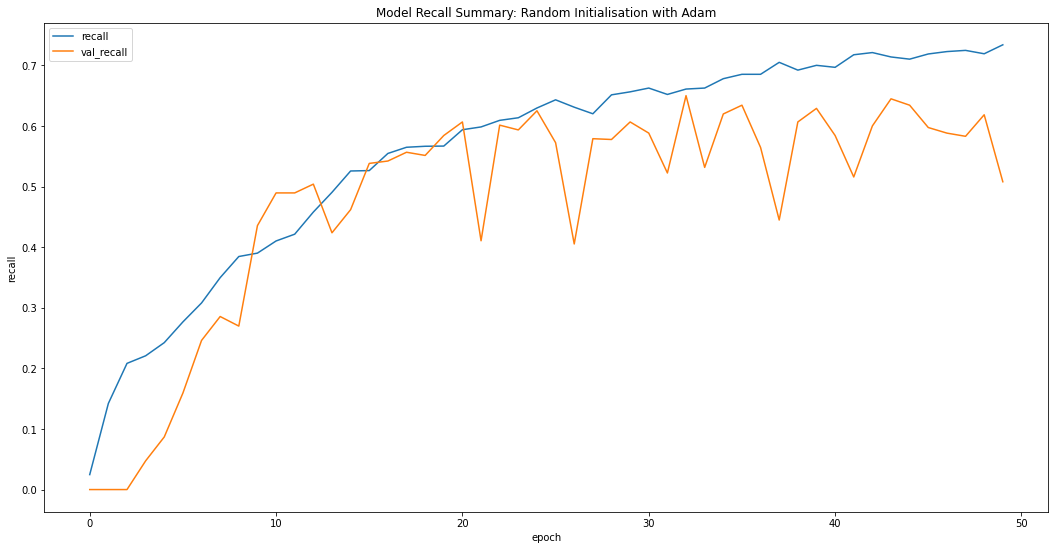

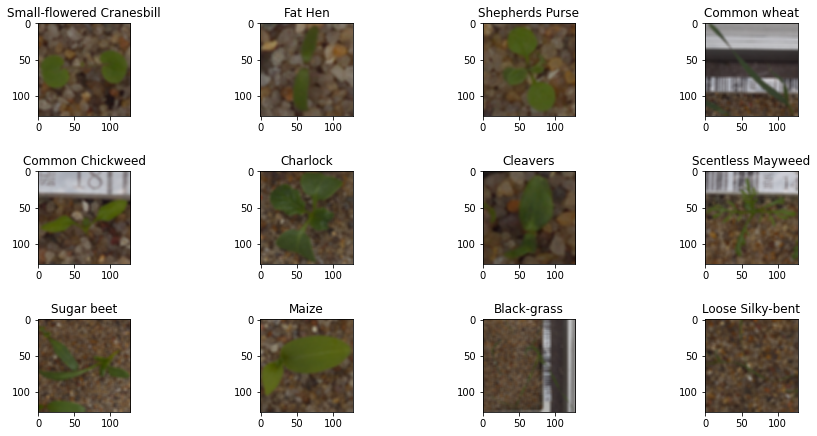

In [ ]:
ShowModelStats(
    history       = model['History'],
    actual_y      = model_data['y_test'],
    predictions_y = y_predictions,
    label         = "Random Initialisation with Adam",
    encoder       = label_binarizer)

DisplayPlantCategoryPlot(main_data)